Talk about random forest and how it works. Write specific context about its use cases here with this data.

In [2]:
# Import libraries and data

import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
import matplotlib.pyplot as plt


In [12]:
df = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [13]:
# Define function for model comparison

def collect_metrics(y_true, y_pred, method_name):
    return {
        'method': method_name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred)
    }

In [14]:
# Prepare data

# Seperate into target and predictors
X_train = df.drop('Diagnosis', axis=1)
y_train = df['Diagnosis']
X_test = test.drop('Diagnosis', axis = 1)
y_test = test['Diagnosis']

# Identify column types
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing and model pipeline
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', 'passthrough', numeric_cols)
])
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=49))),
    ('classifier', RandomForestClassifier(random_state=49))
])

Write about model hyperparameters, why they are important and how grid search can be used to optimize model fitting.

In [16]:
# Perform grid search for optimal hyperparameters with feature selection and update classifier pipeline

# Define hyperparameter grid
param_grid = {
    'feature_selection__estimator__n_estimators': [100],
    'feature_selection__threshold': ['mean', 'median', 0.01],
    'classifier__n_estimators': list(range(25, 200, 25)),
    'classifier__max_depth': [None] + list(range(5, 20, 5)),
    'classifier__min_samples_split': list(range(2, 10)),
    'classifier__min_samples_leaf': list(range(1, 15, 2)),
    'classifier__max_features': ['sqrt', 'log2']
}

# Define GridSearchCV parameters
grid_search = GridSearchCV(
    clf,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Print the results
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Update parameters for subsequent model evaluation
best_clf = grid_search.best_estimator_
clf = best_clf

Fitting 5 folds for each of 9408 candidates, totalling 47040 fits
Best Parameters: {'classifier__max_depth': 10, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100, 'feature_selection__estimator__n_estimators': 100, 'feature_selection__threshold': 'mean'}
Best F1 Score: 0.9324651539325426


In [18]:
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  []),
                                                 ('num', 'passthrough',
                                                  ['Age', 'Gender', 'Ethnicity',
                                                   'EducationLevel', 'BMI',
                                                   'Smoking',
                                                   'AlcoholConsumption',
                                                   'PhysicalActivity',
                                                   'DietQuality',
                                                   'SleepQuality',
                                                   'FamilyHistoryAlzheimers',
                                                   'CardiovascularDisease',
                                                   'Diabetes', 'Depression',
                                                   'HeadInjury...
                                                   'CholesterolTriglycerides',
                                                   'MMSE',
                                                   'FunctionalAssessment',
                                                   'MemoryComplaints',
                                                   'BehavioralProblems', 'ADL',
                                                   'Confusion',
                                                   'Disorientation',
                                                   'PersonalityChanges', ...])])),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=49),
                                 threshold='mean')),
                ('classifier',
                 RandomForestClassifier(max_depth=10, max_features='log2',
                                        random_state=49))])

Feature Importances:
Ethnicity: 0.2741
Smoking: 0.2428
Gender: 0.2090
EducationLevel: 0.1287
BMI: 0.0848
Age: 0.0605


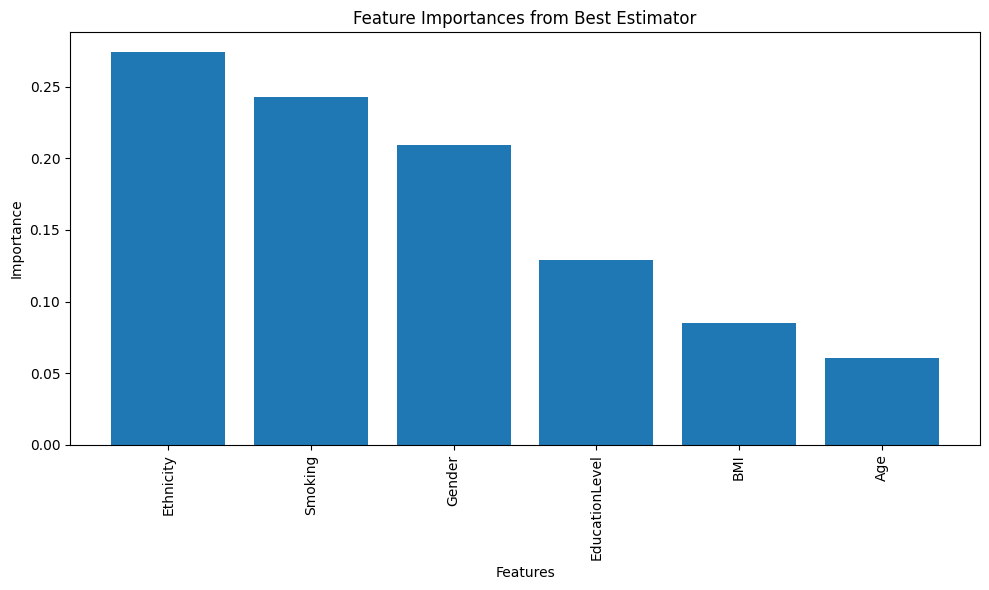

In [19]:
# Extract the classifier from the pipeline.
rf_classifier = clf.named_steps['classifier']

# Retrieve the feature importances from the Random Forest model.
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature importances by sorting them in descending order.
print("Feature Importances:")
for idx in indices:
    print(f"{X.columns[idx]}: {importances[idx]:.4f}")

# Visualize the feature importances using a bar chart.
plt.figure(figsize=(10, 6))
plt.title("Feature Importances from Best Estimator")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), X.columns[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

Talk about k fold cross validation and why we used it.

In [27]:
# Stratified K-Fold cross-validation on the training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=49)

# Lists to store metrics for each fold (for either training or validation)
cv_train_metrics = []
cv_val_metrics = []

for train_idx, val_idx in cv.split(X_train, y_train):
    # Select the fold-specific training and validation sets
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Fit the optimized pipeline on the current fold's training data
    clf.fit(X_tr, y_tr)

    # Predictions on both the fold training set and the validation set
    y_tr_pred = clf.predict(X_tr)
    y_val_pred = clf.predict(X_val)

    # Collect metrics for the fold's training and validation data
    cv_train_metrics.append(collect_metrics(y_tr, y_tr_pred, method_name="CV Fold Train"))
    cv_val_metrics.append(collect_metrics(y_val, y_val_pred, method_name="CV Fold Validation"))


In [30]:
# Fit final model on the full training set
clf.fit(X_train, y_train)

# Make predictions on the full training set and the test set
y_train_pred_final = clf.predict(X_train)
y_test_pred_final = clf.predict(X_test)

# Collect performance metrics from the final model
final_train_metrics = collect_metrics(y_train, y_train_pred_final, method_name="Final Train")
final_test_metrics = collect_metrics(y_test, y_test_pred_final, method_name="Final Test")

# Combine final training and final test metrics into one list for reporting
results = [final_train_metrics, final_test_metrics]

# Create and print the results DataFrame
results_df = pd.DataFrame(results)
print(results_df)


        method  accuracy  precision    recall  f1_score
0  Final Train  0.982548   0.986532  0.963816  0.975042
1   Final Test  0.948837   0.927632  0.927632  0.927632


Talk about leave one out cross validation and make sure to highlight computational inefficiency.

In the final latex document we will need to make sure we use this data to compare model fits using various methods. Also talk about these metrics and why they matter, plus why we didn't use something else such as AUC-ROC.

Summary, even though there is essentially no performance difference between cross validation types here we should use k-fold CV as the preffered method as it is expected to perform better than a standard test-train split on larger and more complex datasets and LOOCV is far too computationally expensive to scale well to other data.

           Accuracy  Precision    Recall  F1 Score  ROC AUC
Test Data  0.948837   0.927632  0.927632  0.927632  0.95629


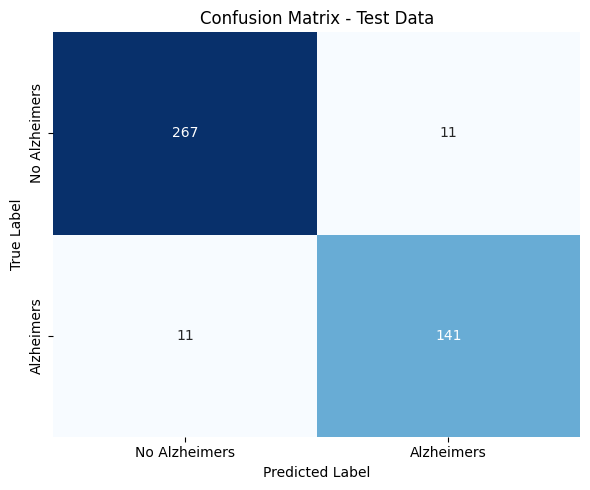

In [31]:
# Fit the final (optimized) model on the training set
clf.fit(X_train, y_train)

# Generate predictions and probability estimates for the test set
y_test_pred = clf.predict(X_test)
y_test_proba = clf.predict_proba(X_test)[:, 1]  # Probability estimates for ROC AUC

# Compute performance metrics for the test data only
test_metrics = {
    'Accuracy': accuracy_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred),
    'Recall': recall_score(y_test, y_test_pred),
    'F1 Score': f1_score(y_test, y_test_pred),
    'ROC AUC': roc_auc_score(y_test, y_test_proba)
}

# Display the performance metrics neatly in a DataFrame
metrics_df = pd.DataFrame(test_metrics, index=['Test Data'])
print(metrics_df)

# Compute the confusion matrix for the test set predictions
cm = confusion_matrix(y_test, y_test_pred)
labels = ['No Alzheimers', 'Alzheimers']  # Adjust these label names as needed

# Plot a heatmap for the confusion matrix using Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Data')
plt.tight_layout()
plt.show()